###  Import all required libraries

In [100]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Models to try
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### Load your dataset

In [101]:

df = pd.read_csv('realistic_malaria_dataset.csv')  # Replace with your filename

# Display first few rows
print("First 5 rows:")
display(df.head())

# Check dataset info
print("\nDataset Info:")
print(df.info())

# Check all column names
print("\nAll Column Names:")
print(df.columns.tolist())

# Check unique values in each column
print("\nUnique values in each column:")
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"{col}: {len(unique_vals)} unique values - Sample: {unique_vals[:5] if len(unique_vals) > 5 else unique_vals}")

First 5 rows:


,Age,Gender,Fever,Headache,Chills,Sweating,Fatigue,Nausea,Vomiting,Muscle_Pain,Diarrhea,Positive_Malaria
0,10,Female,1.0,0.0,0.0,0.0,NaN,1.0,1.0,0.0,0.0,0
1,70,Female,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0
2,20,Male,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0
3,38,Female,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
4,3,Male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               3600 non-null   int64  
 1   Gender            3600 non-null   object 
 2   Fever             3492 non-null   float64
 3   Headache          3492 non-null   float64
 4   Chills            3492 non-null   float64
 5   Sweating          3492 non-null   float64
 6   Fatigue           3492 non-null   float64
 7   Nausea            3492 non-null   float64
 8   Vomiting          3492 non-null   float64
 9   Muscle_Pain       3492 non-null   float64
 10  Diarrhea          3492 non-null   float64
 11  Positive_Malaria  3600 non-null   int64  
dtypes: float64(9), int64(2), object(1)
memory usage: 337.6+ KB
None

All Column Names:
['Age', 'Gender', 'Fever', 'Headache', 'Chills', 'Sweating', 'Fatigue', 'Nausea', 'Vomiting', 'Muscle_Pain', 'Diarrhea', 'Positive_M

### Check data types

In [102]:

print("Data Types:")
print(df.dtypes)

# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nNon-numeric columns: {non_numeric_cols}")

# Check for categorical columns that should be numeric
print("\nSample values from non-numeric columns:")
for col in non_numeric_cols[:3]:  # Show first 3
    print(f"{col}: {df[col].unique()[:10]}")

Data Types:
Age                   int64
Gender               object
Fever               float64
Headache            float64
Chills              float64
Sweating            float64
Fatigue             float64
Nausea              float64
Vomiting            float64
Muscle_Pain         float64
Diarrhea            float64
Positive_Malaria      int64
dtype: object

Non-numeric columns: ['Gender']

Sample values from non-numeric columns:
Gender: ['Female' 'Male']


### Create a copy to work with

In [103]:

df_processed = df.copy()

# If there are categorical variables, let's handle them
if non_numeric_cols:
    print("Handling categorical variables...")

    # Use LabelEncoder for categorical columns
    label_encoders = {}

    for col in non_numeric_cols:
        # Don't encode if it's already the target variable or if it's supposed to be numeric
        if col != 'Positive_Malaria':
            print(f"Encoding column: {col}")
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
            print(f"  Encoded values mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

    # Check if Positive_Malaria needs encoding
    if 'Positive_Malaria' in non_numeric_cols:
        print("Encoding target variable 'Positive_Malaria'...")
        le_target = LabelEncoder()
        df_processed['Positive_Malaria'] = le_target.fit_transform(df_processed['Positive_Malaria'].astype(str))
        print(f"  Mapping: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
else:
    print("No categorical variables found (all are numeric)")

Handling categorical variables...
Encoding column: Gender
  Encoded values mapping: {'Female': np.int64(0), 'Male': np.int64(1)}


### Check for missing values

Missing values in each column:
Age                   0
Gender                0
Fever               108
Headache            108
Chills              108
Sweating            108
Fatigue             108
Nausea              108
Vomiting            108
Muscle_Pain         108
Diarrhea            108
Positive_Malaria      0
dtype: int64


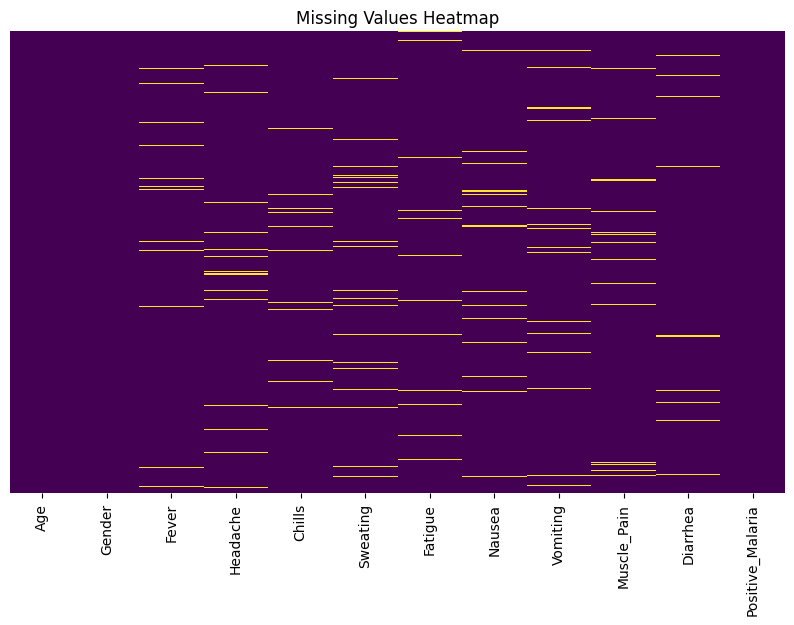

In [104]:

print("Missing values in each column:")
missing_values = df_processed.isnull().sum()
print(missing_values)

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()
else:
    print("No missing values found!")

### Handle missing values if any

In [105]:

if missing_values.sum() > 0:
    print("Handling missing values...")

    # Get numeric columns
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()

    # Separate target from features
    if 'Positive_Malaria' in df_processed.columns:
        target_col = 'Positive_Malaria'
        feature_cols = [col for col in numeric_cols if col != target_col]
    else:
        feature_cols = numeric_cols

    # Create imputer for features
    imputer = SimpleImputer(strategy='median')
    df_processed[feature_cols] = imputer.fit_transform(df_processed[feature_cols])

    # For target variable, drop rows with missing values
    if target_col in df_processed.columns and df_processed[target_col].isnull().sum() > 0:
        print(f"Dropping {df_processed[target_col].isnull().sum()} rows with missing target values")
        df_processed = df_processed.dropna(subset=[target_col])

    print("Missing values after handling:")
    print(df_processed.isnull().sum())

Handling missing values...
Missing values after handling:
Age                 0
Gender              0
Fever               0
Headache            0
Chills              0
Sweating            0
Fatigue             0
Nausea              0
Vomiting            0
Muscle_Pain         0
Diarrhea            0
Positive_Malaria    0
dtype: int64


### Check distribution of target variable

Target variable distribution:
Positive_Malaria
0    2659
1     941
Name: count, dtype: int64

Percentage distribution:
Positive_Malaria
0    73.861111
1    26.138889
Name: proportion, dtype: float64


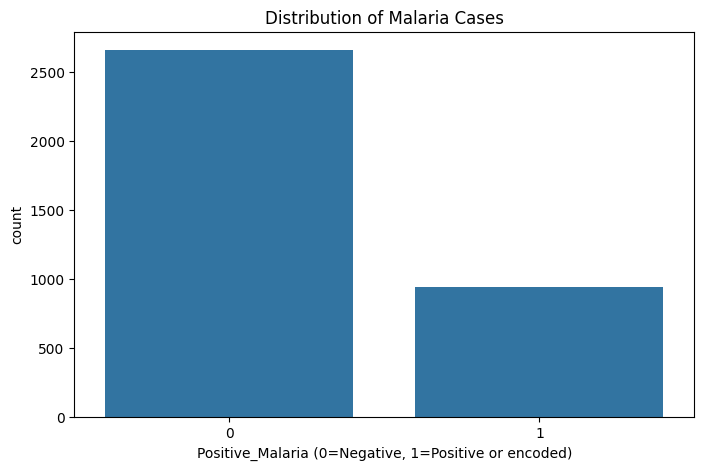

In [106]:

if 'Positive_Malaria' in df_processed.columns:
    print("Target variable distribution:")
    target_counts = df_processed['Positive_Malaria'].value_counts()
    print(target_counts)

    # Convert to readable labels if we encoded
    if 'le_target' in locals():
        # Reverse mapping for display
        reverse_mapping = {v: k for k, v in zip(le_target.classes_, le_target.transform(le_target.classes_))}
        print(f"\nMapping: {reverse_mapping}")

    print(f"\nPercentage distribution:")
    print(df_processed['Positive_Malaria'].value_counts(normalize=True) * 100)

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Positive_Malaria', data=df_processed)
    plt.title('Distribution of Malaria Cases')
    plt.xlabel('Positive_Malaria (0=Negative, 1=Positive or encoded)')
    plt.show()

### Now calculate correlation matrix

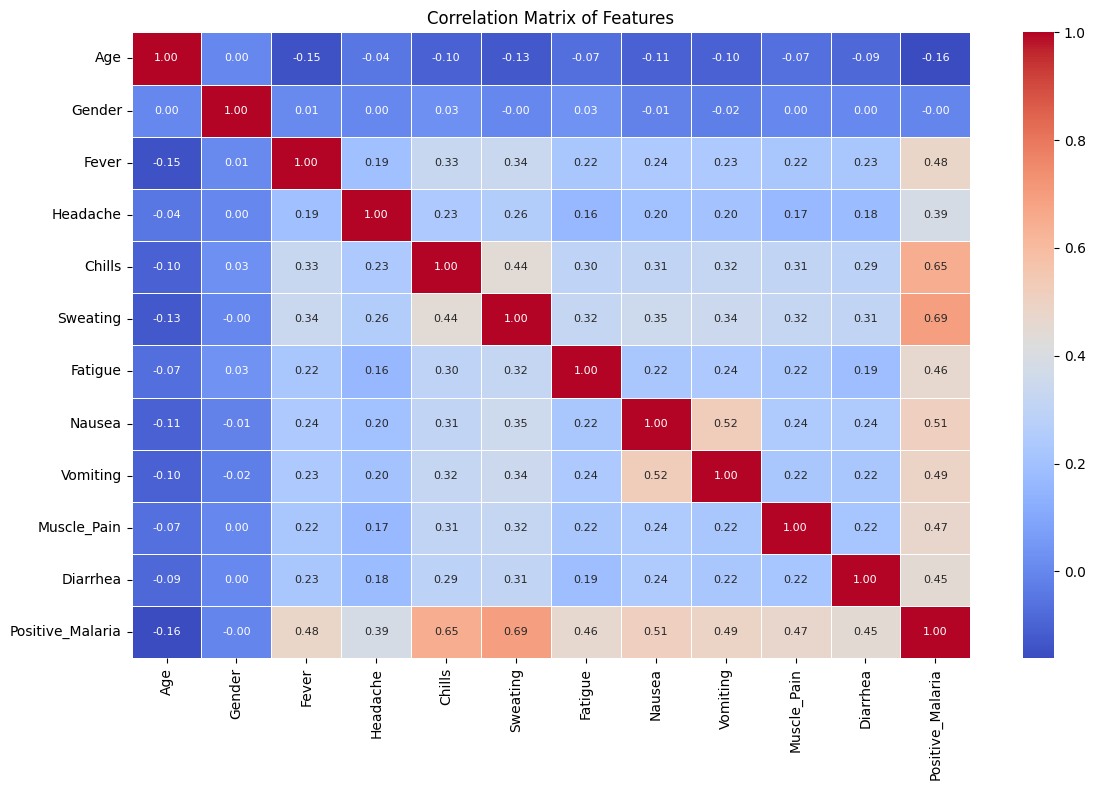

Correlation with Positive_Malaria:
Positive_Malaria    1.000000
Sweating            0.693294
Chills              0.648891
Nausea              0.511453
Vomiting            0.487733
Fever               0.482064
Muscle_Pain         0.470836
Fatigue             0.464633
Diarrhea            0.447387
Headache            0.387245
Gender             -0.004846
Age                -0.161258
Name: Positive_Malaria, dtype: float64


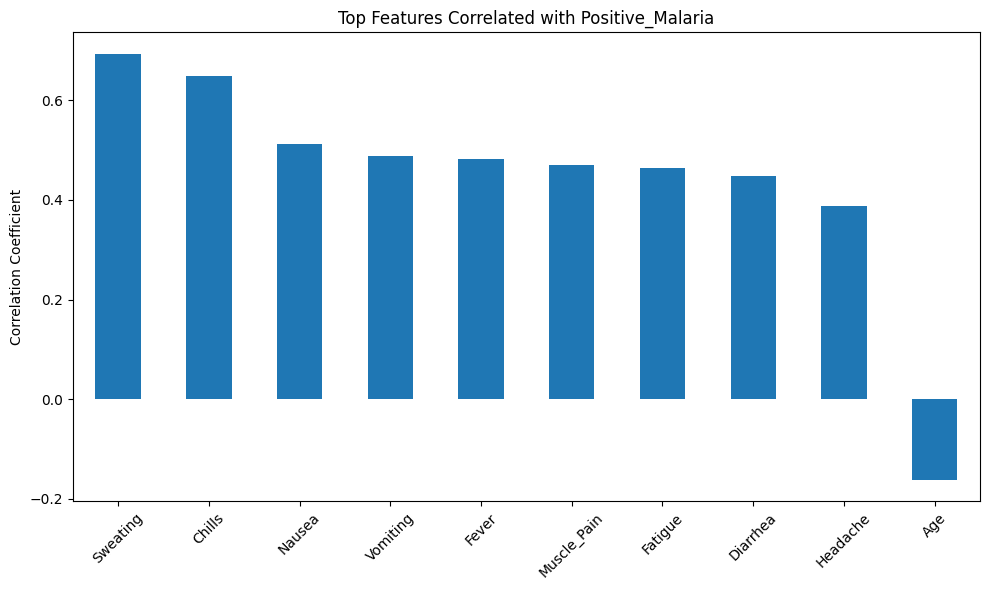

In [124]:

try:
    correlation_matrix = df_processed.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
                annot_kws={'size': 8})
    plt.title('Correlation Matrix of Features')
    plt.tight_layout()
    plt.show()

    # Check correlation with target variable
    if 'Positive_Malaria' in correlation_matrix.columns:
        print("Correlation with Positive_Malaria:")
        target_corr = correlation_matrix['Positive_Malaria'].sort_values(ascending=False)
        print(target_corr)

        # Plot top correlations
        top_features = target_corr.abs().sort_values(ascending=False).index[1:11]  # Exclude self
        plt.figure(figsize=(10, 6))
        target_corr[top_features].plot(kind='bar')
        plt.title('Top Features Correlated with Positive_Malaria')
        plt.ylabel('Correlation Coefficient')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error in correlation analysis: {e}")
    print("Showing first few rows of processed data instead:")
    display(df_processed.head())

### Plot distributions of numeric features

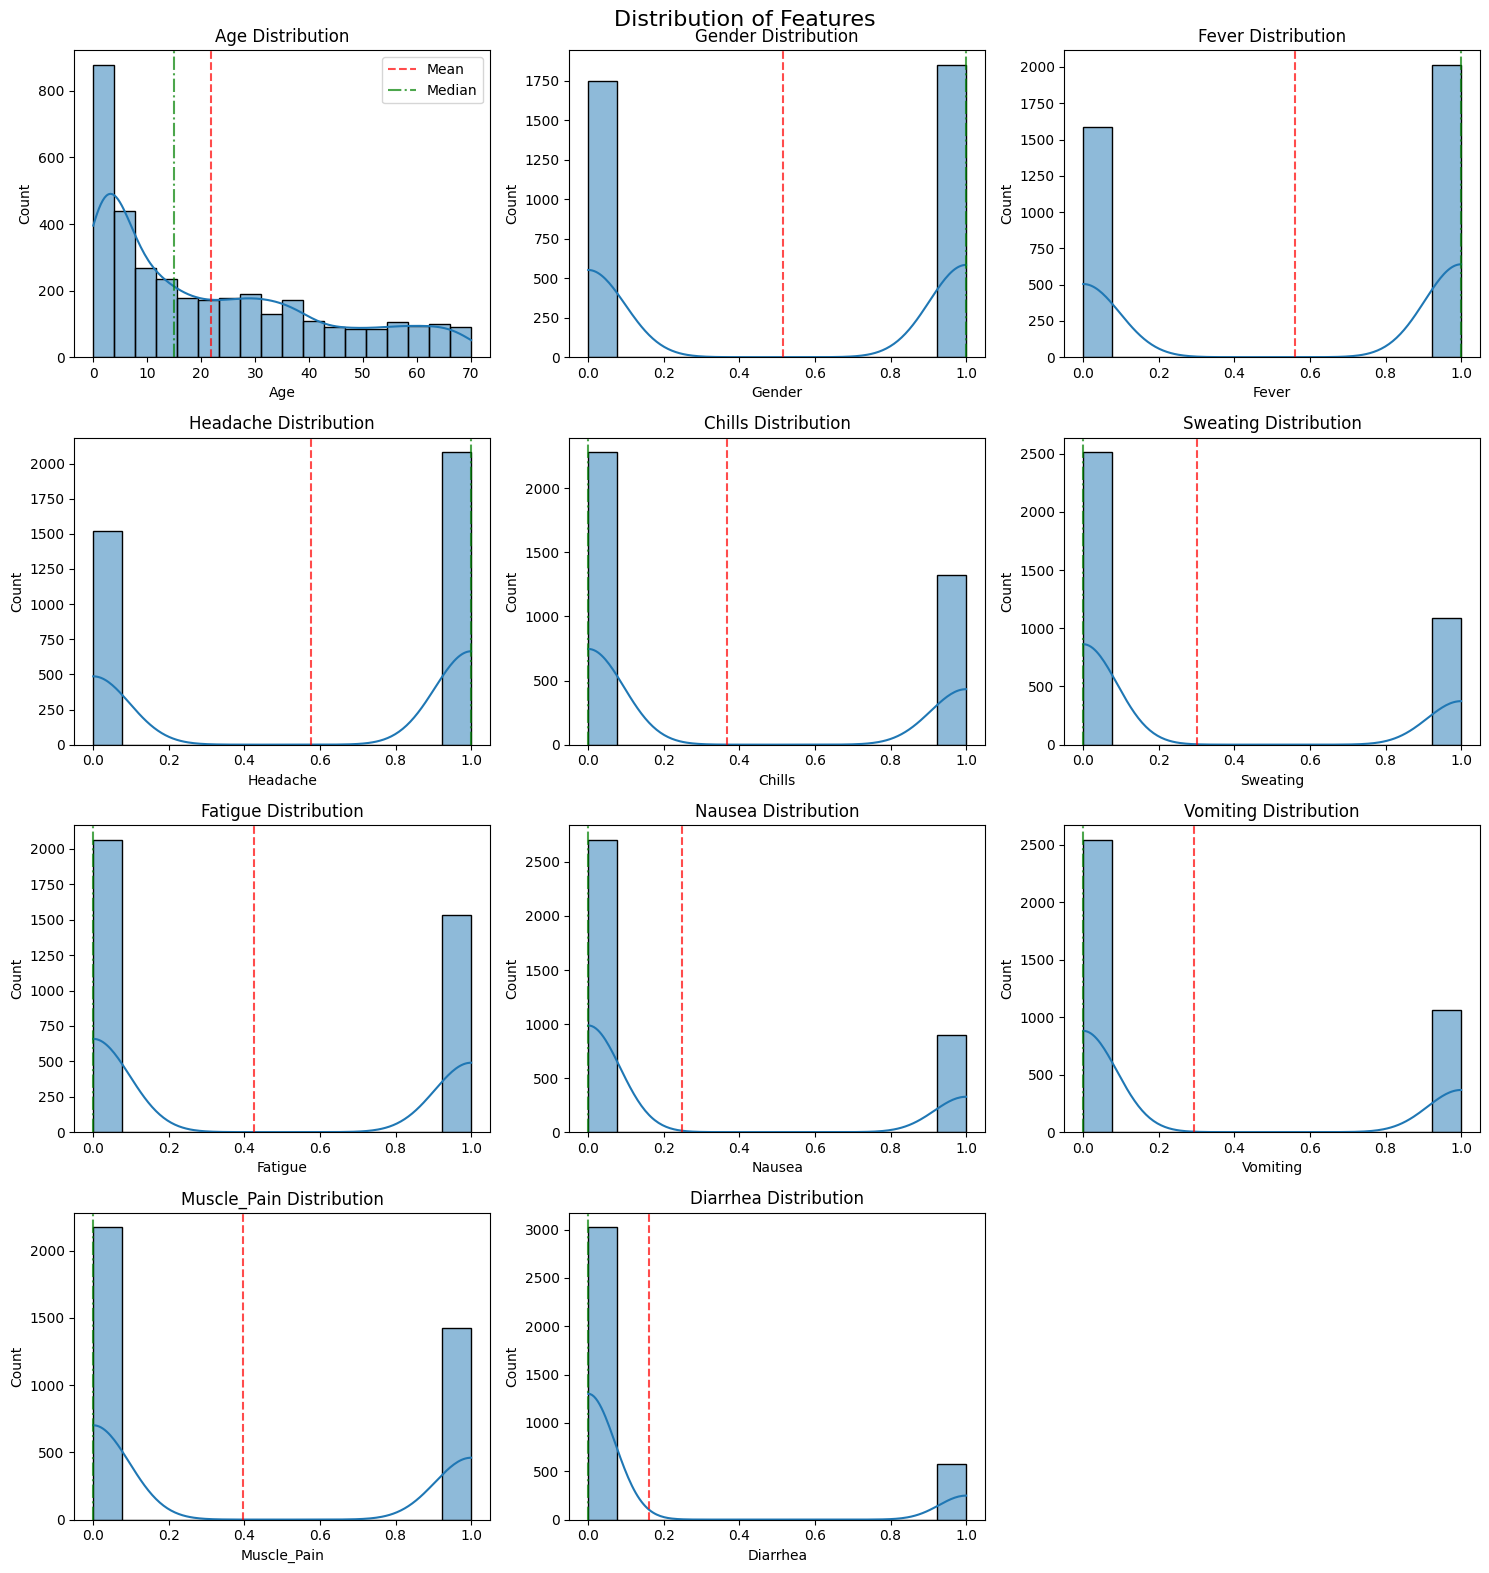

In [108]:

numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'Positive_Malaria' in numeric_features:
    numeric_features.remove('Positive_Malaria')

# Plot histograms for numeric features
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
fig.suptitle('Distribution of Features', fontsize=16)

for idx, feature in enumerate(numeric_features):
    row = idx // n_cols
    col = idx % n_cols
    if n_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col] if n_cols > 1 else axes

    sns.histplot(data=df_processed, x=feature, ax=ax, kde=True)
    ax.set_title(f'{feature} Distribution')

    # Add mean and median lines
    ax.axvline(df_processed[feature].mean(), color='red', linestyle='--', alpha=0.7, label='Mean')
    ax.axvline(df_processed[feature].median(), color='green', linestyle='-.', alpha=0.7, label='Median')
    if idx == 0:  # Add legend only once
        ax.legend()

# Hide empty subplots
for idx in range(len(numeric_features), n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    if n_rows > 1:
        axes[row, col].axis('off')
    else:
        axes[col].axis('off()' if n_cols > 1 else '')

plt.tight_layout()
plt.show()

### Separate features and target

In [109]:

if 'Positive_Malaria' in df_processed.columns:
    X = df_processed.drop('Positive_Malaria', axis=1)  # Features
    y = df_processed['Positive_Malaria']  # Target

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"\nFeature columns: {X.columns.tolist()}")

    # Display sample of features
    print("\nSample of features:")
    display(X.head())

    # Display target distribution
    print("\nTarget value counts:")
    print(y.value_counts())
else:
    print("Error: 'Positive_Malaria' column not found in dataset")
    print("Available columns:", df_processed.columns.tolist())

Features shape: (3600, 11)
Target shape: (3600,)

Feature columns: ['Age', 'Gender', 'Fever', 'Headache', 'Chills', 'Sweating', 'Fatigue', 'Nausea', 'Vomiting', 'Muscle_Pain', 'Diarrhea']

Sample of features:


,Age,Gender,Fever,Headache,Chills,Sweating,Fatigue,Nausea,Vomiting,Muscle_Pain,Diarrhea
0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Target value counts:
Positive_Malaria
0    2659
1     941
Name: count, dtype: int64


### Check if X and y are defined

Training set size: (2880, 11)
Testing set size: (720, 11)

Training target distribution:
Counts:
Positive_Malaria
0    2127
1     753
Name: count, dtype: int64
Percentages:
Positive_Malaria
0    73.854167
1    26.145833
Name: proportion, dtype: float64

Testing target distribution:
Counts:
Positive_Malaria
0    532
1    188
Name: count, dtype: int64
Percentages:
Positive_Malaria
0    73.888889
1    26.111111
Name: proportion, dtype: float64


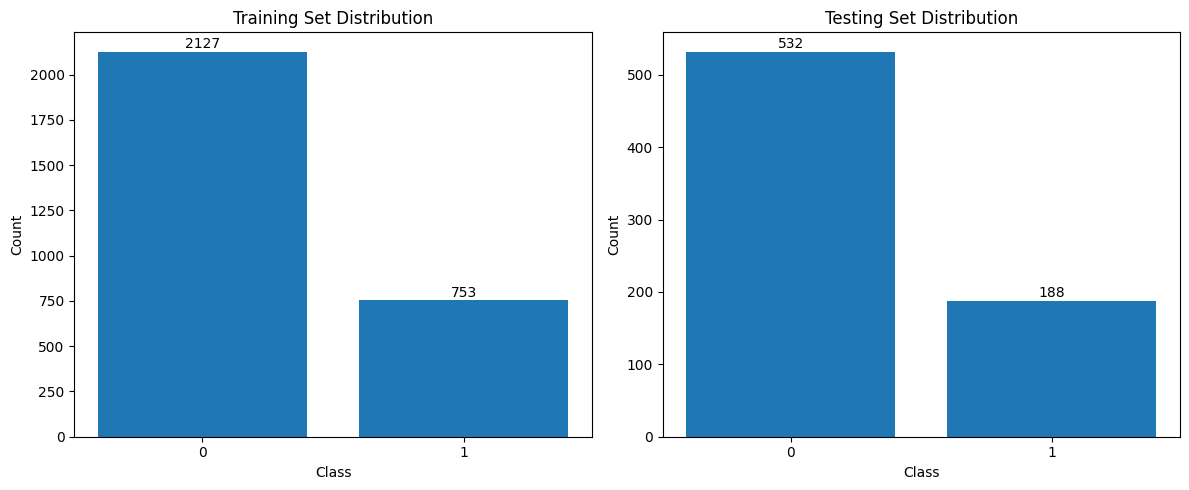

In [110]:

if 'X' in locals() and 'y' in locals():
    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    # Check class distribution
    print("\nTraining target distribution:")
    train_counts = y_train.value_counts()
    print(f"Counts:\n{train_counts}")
    print(f"Percentages:\n{y_train.value_counts(normalize=True) * 100}")

    print("\nTesting target distribution:")
    test_counts = y_test.value_counts()
    print(f"Counts:\n{test_counts}")
    print(f"Percentages:\n{y_test.value_counts(normalize=True) * 100}")

    # Visualize the split
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Training distribution
    axes[0].bar(train_counts.index.astype(str), train_counts.values)
    axes[0].set_title('Training Set Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(train_counts.values):
        axes[0].text(i, v + max(train_counts.values)*0.01, str(v), ha='center')

    # Testing distribution
    axes[1].bar(test_counts.index.astype(str), test_counts.values)
    axes[1].set_title('Testing Set Distribution')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')
    for i, v in enumerate(test_counts.values):
        axes[1].text(i, v + max(test_counts.values)*0.01, str(v), ha='center')

    plt.tight_layout()
    plt.show()

else:
    print("Error: X and y are not defined. Please run previous cells first.")

### Initialize scaler

Scaled training data statistics:
Mean of each feature (should be ~0):
Age            0.0
Gender         0.0
Fever         -0.0
Headache      -0.0
Chills         0.0
Sweating       0.0
Fatigue       -0.0
Nausea         0.0
Vomiting       0.0
Muscle_Pain    0.0
Diarrhea      -0.0
dtype: float64

Standard deviation of each feature (should be ~1):
Age            1.0
Gender         1.0
Fever          1.0
Headache       1.0
Chills         1.0
Sweating       1.0
Fatigue        1.0
Nausea         1.0
Vomiting       1.0
Muscle_Pain    1.0
Diarrhea       1.0
dtype: float64

Scaled training data sample (first 5 rows):


,Age,Gender,Fever,Headache,Chills,Sweating,Fatigue,Nausea,Vomiting,Muscle_Pain,Diarrhea
1647,1.325281,0.965189,0.888155,-1.171462,1.320173,-0.657903,-0.870155,-0.576281,-0.629305,1.238136,-0.439926
1340,-0.924245,0.965189,0.888155,0.853634,1.320173,1.519982,1.149221,1.735264,1.589054,-0.807666,2.273109
1902,-0.288509,0.965189,0.888155,0.853634,1.320173,-0.657903,-0.870155,-0.576281,-0.629305,1.238136,-0.439926
3384,-0.875342,0.965189,0.888155,0.853634,-0.757476,-0.657903,-0.870155,-0.576281,-0.629305,-0.807666,-0.439926
3069,0.249421,-1.036067,0.888155,0.853634,1.320173,-0.657903,1.149221,1.735264,1.589054,1.238136,2.273109


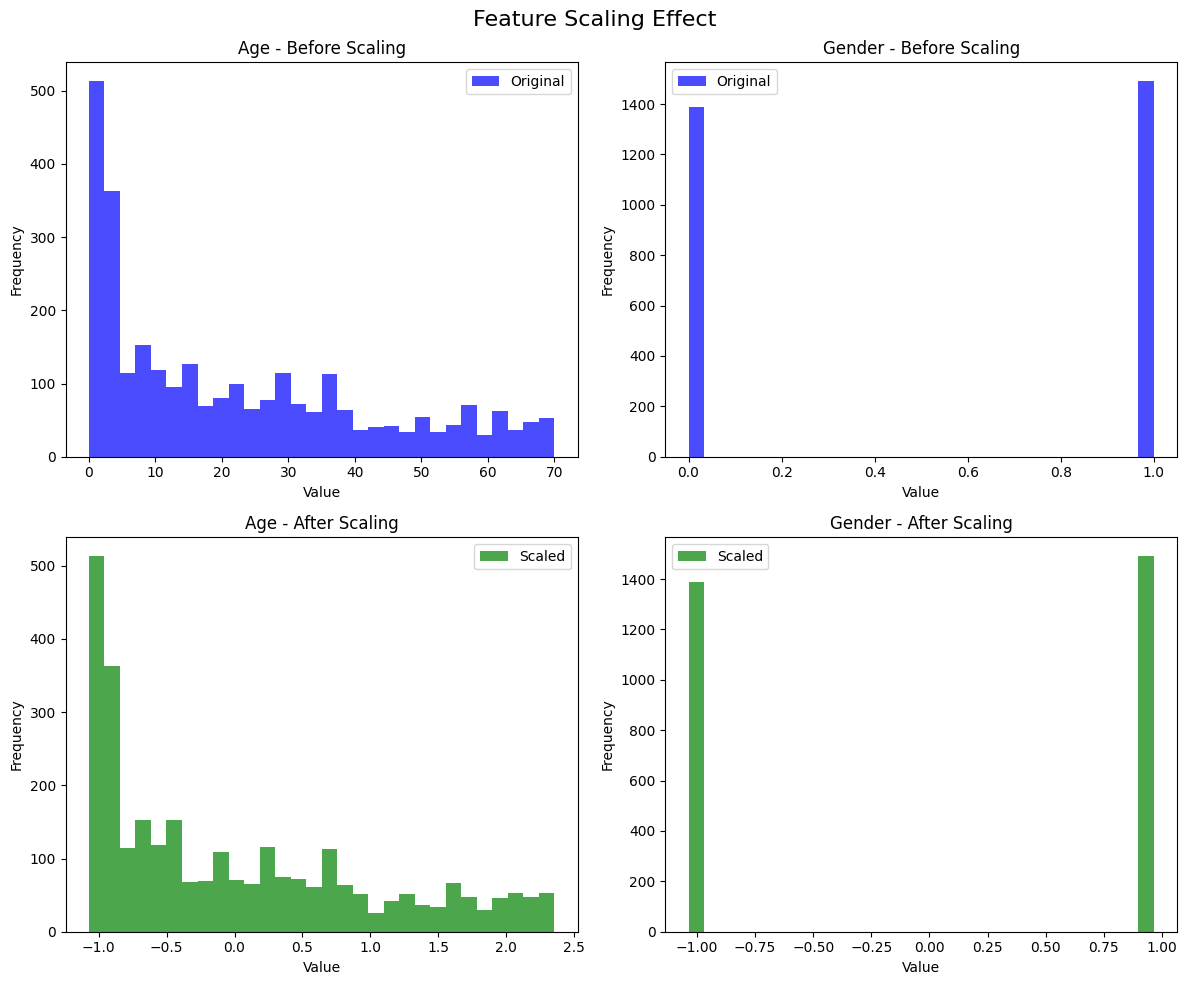

In [111]:

scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Scaled training data statistics:")
print("Mean of each feature (should be ~0):")
print(X_train_scaled_df.mean().round(3))

print("\nStandard deviation of each feature (should be ~1):")
print(X_train_scaled_df.std().round(3))

print("\nScaled training data sample (first 5 rows):")
display(X_train_scaled_df.head())

# Visualize scaling effect on first few features
if len(X.columns) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Before scaling
    for i, feature in enumerate(X.columns[:2]):
        axes[0, i].hist(X_train[feature], bins=30, alpha=0.7, color='blue', label='Original')
        axes[0, i].set_title(f'{feature} - Before Scaling')
        axes[0, i].set_xlabel('Value')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].legend()

    # After scaling
    for i, feature in enumerate(X.columns[:2]):
        axes[1, i].hist(X_train_scaled_df[feature], bins=30, alpha=0.7, color='green', label='Scaled')
        axes[1, i].set_title(f'{feature} - After Scaling')
        axes[1, i].set_xlabel('Value')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].legend()

    plt.suptitle('Feature Scaling Effect', fontsize=16)
    plt.tight_layout()
    plt.show()

### Dictionary to store models

In [112]:

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dictionary to store results
results = {}
predictions = {}

# Train each model
print("Training models...")
print("=" * 60)

for name, model in models.items():
    print(f"\nTraining {name}...")

    try:
        # Train model
        model.fit(X_train_scaled_df, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled_df)
        y_pred_train = model.predict(X_train_scaled_df)

        # Calculate accuracies
        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_pred_train)

        # Store results
        results[name] = {
            'model': model,
            'test_accuracy': test_accuracy,
            'train_accuracy': train_accuracy,
            'y_pred': y_pred,
            'predictions_train': y_pred_train
        }

        predictions[name] = y_pred

        print(f"  Training Accuracy: {train_accuracy:.4f}")
        print(f"  Testing Accuracy:  {test_accuracy:.4f}")
        print(f"  Overfitting (Train-Test diff): {abs(train_accuracy - test_accuracy):.4f}")

    except Exception as e:
        print(f"  Error training {name}: {e}")
        results[name] = None

print("\n" + "=" * 60)
print("All models trained successfully!")

Training models...

Training Logistic Regression...
  Training Accuracy: 0.9788
  Testing Accuracy:  0.9819
  Overfitting (Train-Test diff): 0.0031

Training Random Forest...
  Training Accuracy: 0.9990
  Testing Accuracy:  0.9792
  Overfitting (Train-Test diff): 0.0198

Training Decision Tree...
  Training Accuracy: 0.9990
  Testing Accuracy:  0.9625
  Overfitting (Train-Test diff): 0.0365

Training SVM...
  Training Accuracy: 0.9830
  Testing Accuracy:  0.9875
  Overfitting (Train-Test diff): 0.0045

Training K-Nearest Neighbors...
  Training Accuracy: 0.9788
  Testing Accuracy:  0.9861
  Overfitting (Train-Test diff): 0.0073

Training Gradient Boosting...
  Training Accuracy: 0.9847
  Testing Accuracy:  0.9778
  Overfitting (Train-Test diff): 0.0069

All models trained successfully!


### Create comparison dataframe

Model Performance Comparison:


,Model,Train_Accuracy,Test_Accuracy,Overfitting
0,SVM,0.982986,0.987500,0.004514
1,K-Nearest Neighbors,0.978819,0.986111,0.007292
2,Logistic Regression,0.978819,0.981944,0.003125
3,Random Forest,0.998958,0.979167,0.019792
4,Gradient Boosting,0.984722,0.977778,0.006944
5,Decision Tree,0.998958,0.962500,0.036458


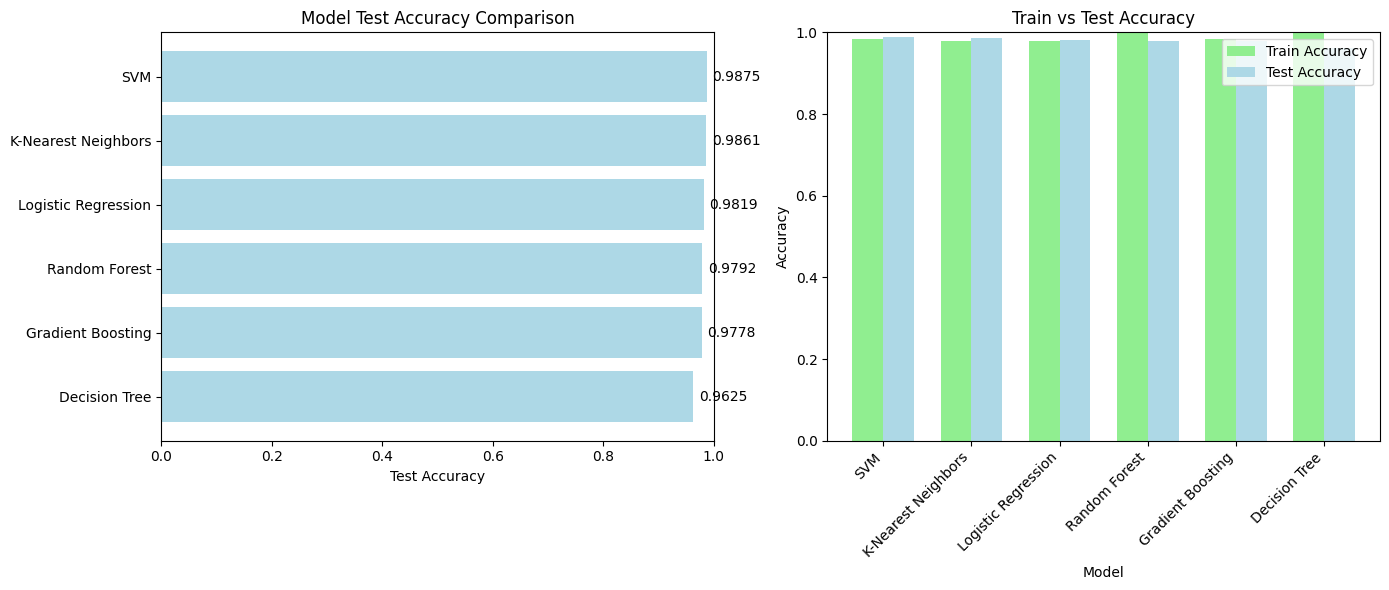


Best Model: SVM
Best Model Test Accuracy: 0.9875


In [113]:

performance_data = []
for name, result in results.items():
    if result is not None:
        performance_data.append({
            'Model': name,
            'Train_Accuracy': result['train_accuracy'],
            'Test_Accuracy': result['test_accuracy'],
            'Overfitting': abs(result['train_accuracy'] - result['test_accuracy'])
        })

if performance_data:
    results_df = pd.DataFrame(performance_data)
    results_df = results_df.sort_values('Test_Accuracy', ascending=False).reset_index(drop=True)

    print("Model Performance Comparison:")
    display(results_df)

    # Visualize model performance
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Test Accuracy comparison
    bars1 = axes[0].barh(results_df['Model'], results_df['Test_Accuracy'], color='lightblue')
    axes[0].set_xlabel('Test Accuracy')
    axes[0].set_title('Model Test Accuracy Comparison')
    axes[0].set_xlim([0, 1])
    axes[0].invert_yaxis()

    # Add accuracy values on bars
    for bar in bars1:
        width = bar.get_width()
        axes[0].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}', ha='left', va='center')

    # Train vs Test Accuracy
    x = np.arange(len(results_df))
    width = 0.35

    axes[1].bar(x - width/2, results_df['Train_Accuracy'], width, label='Train Accuracy', color='lightgreen')
    axes[1].bar(x + width/2, results_df['Test_Accuracy'], width, label='Test Accuracy', color='lightblue')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Train vs Test Accuracy')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Identify best model
    best_model_name = results_df.iloc[0]['Model']
    best_model_info = results[best_model_name]

    print(f"\nBest Model: {best_model_name}")
    print(f"Best Model Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")

else:
    print("No models were successfully trained.")

### Get best model

Detailed Evaluation of Best Model: SVM

Confusion Matrix:
[[527   5]
 [  4 184]]


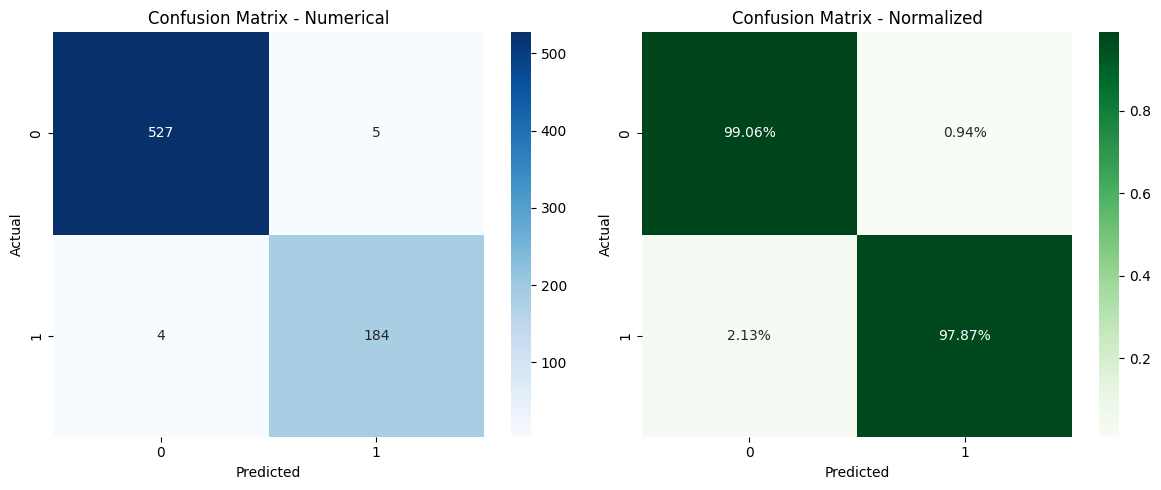


Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99       532
    Positive       0.97      0.98      0.98       188

    accuracy                           0.99       720
   macro avg       0.98      0.98      0.98       720
weighted avg       0.99      0.99      0.99       720


Key Metrics:
Precision: 0.9735
Recall: 0.9787
F1-Score: 0.9761

Model supports probability predictions


In [114]:

if 'best_model_name' in locals() and best_model_name in results:
    best_model_info = results[best_model_name]
    best_model = best_model_info['model']

    print(f"Detailed Evaluation of Best Model: {best_model_name}")
    print("=" * 60)

    # Make predictions
    y_pred = best_model_info['y_pred']

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Numerical confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix - Numerical')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1])
    axes[1].set_title('Confusion Matrix - Normalized')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Calculate additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nKey Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Check for probability predictions
    if hasattr(best_model, 'predict_proba'):
        y_pred_proba = best_model.predict_proba(X_test_scaled_df)[:, 1]
        print(f"\nModel supports probability predictions")
    else:
        print(f"\nModel does not support probability predictions")

else:
    print("Best model not found. Please run previous cells first.")

### Check if best model supports feature importance

Feature Importance Analysis for SVM
SVM does not provide feature importance or coefficients.

Feature Correlation with Target (Alternative View):


,Feature,Correlation,Abs_Correlation
0,Sweating,0.693294,0.693294
1,Chills,0.648891,0.648891
2,Nausea,0.511453,0.511453
3,Vomiting,0.487733,0.487733
4,Fever,0.482064,0.482064
5,Muscle_Pain,0.470836,0.470836
6,Fatigue,0.464633,0.464633
7,Diarrhea,0.447387,0.447387
8,Headache,0.387245,0.387245
10,Age,-0.161258,0.161258


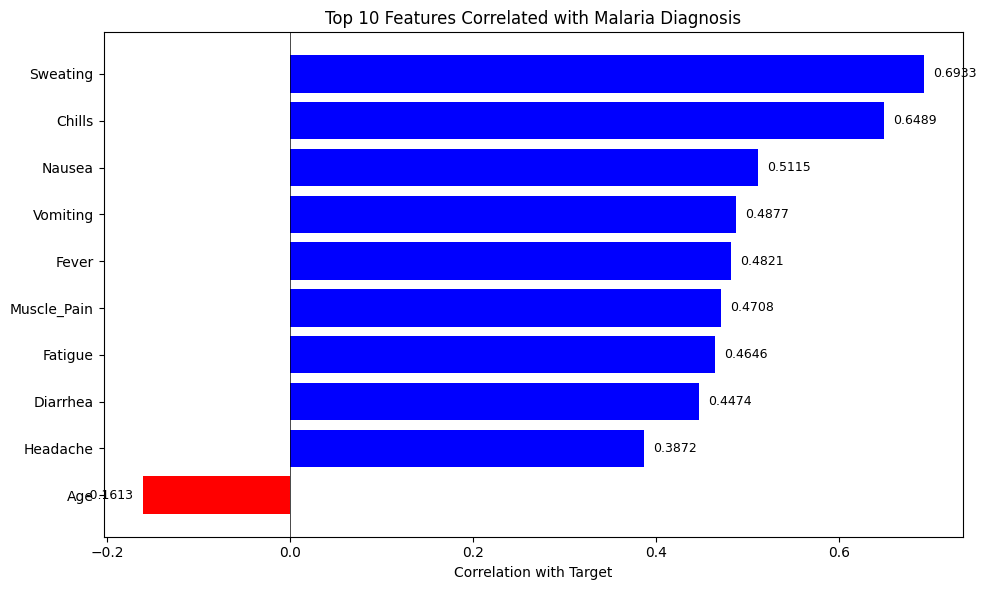

In [115]:

if 'best_model' in locals():
    print(f"Feature Importance Analysis for {best_model_name}")
    print("=" * 60)

    if hasattr(best_model, 'feature_importances_'):
        # Tree-based models (Random Forest, Decision Tree, Gradient Boosting)
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("Feature Importance Scores:")
        display(feature_importance)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        bars = plt.barh(feature_importance['Feature'][:15],  # Top 15 features
                       feature_importance['Importance'][:15],
                       color='lightcoral')
        plt.xlabel('Importance Score')
        plt.title(f'Top 15 Feature Importance - {best_model_name}')
        plt.gca().invert_yaxis()

        # Add values on bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}', ha='left', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

    elif hasattr(best_model, 'coef_'):
        # Linear models (Logistic Regression)
        coefficients = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': best_model.coef_[0],
            'Abs_Coefficient': np.abs(best_model.coef_[0])
        }).sort_values('Abs_Coefficient', ascending=False)

        print("Feature Coefficients:")
        display(coefficients)

        # Plot coefficients
        plt.figure(figsize=(10, 6))
        top_features = coefficients.head(15)
        colors = ['red' if coef < 0 else 'blue' for coef in top_features['Coefficient']]
        bars = plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
        plt.xlabel('Coefficient Value')
        plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.gca().invert_yaxis()

        # Add values on bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + (0.01 if width >= 0 else -0.01),
                    bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}',
                    ha='left' if width >= 0 else 'right',
                    va='center',
                    fontsize=9)

        plt.tight_layout()
        plt.show()

    else:
        print(f"{best_model_name} does not provide feature importance or coefficients.")

    # Correlation with target (alternative feature importance)
    print("\nFeature Correlation with Target (Alternative View):")
    if 'X' in locals() and 'y' in locals():
        # Calculate correlation for all features
        df_corr = pd.concat([X, y.rename('Target')], axis=1)
        corr_with_target = df_corr.corr()['Target'].drop('Target').sort_values(ascending=False)

        corr_df = pd.DataFrame({
            'Feature': corr_with_target.index,
            'Correlation': corr_with_target.values,
            'Abs_Correlation': np.abs(corr_with_target.values)
        }).sort_values('Abs_Correlation', ascending=False)

        display(corr_df.head(10))

        # Plot top correlations
        plt.figure(figsize=(10, 6))
        top_corr = corr_df.head(10)
        colors = ['red' if corr < 0 else 'blue' for corr in top_corr['Correlation']]
        bars = plt.barh(top_corr['Feature'], top_corr['Correlation'], color=colors)
        plt.xlabel('Correlation with Target')
        plt.title('Top 10 Features Correlated with Malaria Diagnosis')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.gca().invert_yaxis()

        # Add values on bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + (0.01 if width >= 0 else -0.01),
                    bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}',
                    ha='left' if width >= 0 else 'right',
                    va='center',
                    fontsize=9)

        plt.tight_layout()
        plt.show()

### First, let's ensure we have the best model identified

In [116]:

print("Checking available models and selecting the best one...")

if 'results' in locals() and len(results) > 0:
    # Find the model with highest test accuracy
    best_model_name = None
    best_accuracy = -1

    for model_name, model_info in results.items():
        if model_info is not None:
            accuracy = model_info['test_accuracy']
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_name = model_name

    if best_model_name:
        print(f"Best model identified: {best_model_name} with accuracy: {best_accuracy:.4f}")
        best_model = results[best_model_name]['model']

        # Save the best model
        import joblib
        import os

        # Create a directory for saving models if it doesn't exist
        if not os.path.exists('saved_models'):
            os.makedirs('saved_models')

        # Save the model
        model_filename = 'saved_models/malaria_best_model.pkl'
        joblib.dump(best_model, model_filename)
        print(f"Best model saved as: {model_filename}")

        # Save the scaler
        scaler_filename = 'saved_models/malaria_scaler.pkl'
        joblib.dump(scaler, scaler_filename)
        print(f"Scaler saved as: {scaler_filename}")

        # Save all models
        all_models_filename = 'saved_models/all_malaria_models.pkl'
        joblib.dump(models, all_models_filename)
        print(f"All models saved as: {all_models_filename}")

        # Save feature names
        feature_names = X.columns.tolist()
        features_filename = 'saved_models/feature_names.pkl'
        joblib.dump(feature_names, features_filename)
        print(f"Feature names saved as: {features_filename}")

        # Save results
        results_filename = 'saved_models/model_results.pkl'
        joblib.dump(results, results_filename)
        print(f"Model results saved as: {results_filename}")

        print("\nAll files saved successfully in 'saved_models' directory!")

    else:
        print("No valid models found in results.")
else:
    print("Results dictionary not found or empty. Please run model training cells first.")

Checking available models and selecting the best one...
Best model identified: SVM with accuracy: 0.9875
Best model saved as: saved_models/malaria_best_model.pkl
Scaler saved as: saved_models/malaria_scaler.pkl
All models saved as: saved_models/all_malaria_models.pkl
Feature names saved as: saved_models/feature_names.pkl
Model results saved as: saved_models/model_results.pkl

All files saved successfully in 'saved_models' directory!


In [117]:
def predict_malaria_fixed(symptoms_dict):
    """
    Predict malaria based on symptoms

    Parameters:
    - symptoms_dict: dictionary with symptom values

    Example:
    {
        'Age': 25,
        'Gender': 1,  # 1 for Male, 0 for Female (after encoding)
        'Fever': 1,
        'Headache': 1,
        'Chills': 1,
        'Sweating': 0,
        'Fatigue': 1,
        'Nausea': 0,
        'Vomiting': 0,
        'Muscle_Pain': 1,
        'Diarrhea': 0
    }
    """
    # Get global variables
    global best_model, scaler, X

    # Create a dataframe with all features
    features_df = pd.DataFrame(columns=X.columns)

    # Initialize with zeros for all features
    for col in X.columns:
        features_df.loc[0, col] = 0

    # Update with provided symptoms
    missing_features = []
    for symptom, value in symptoms_dict.items():
        if symptom in features_df.columns:
            features_df.loc[0, symptom] = value
        else:
            missing_features.append(symptom)

    if missing_features:
        print(f"Warning: These features were not in the model: {missing_features}")
        print(f"Available features: {list(X.columns)}")

    # Check if all features are provided
    if len(symptoms_dict) < len(X.columns):
        print(f"\nNote: Only {len(symptoms_dict)} features provided out of {len(X.columns)} expected.")
        print("Missing features will be set to 0 (default).")

    # Scale the features
    features_scaled = scaler.transform(features_df)

    # ✅ FIX: Convert scaled features back to DataFrame with column names
    features_scaled_df = pd.DataFrame(features_scaled, columns=X.columns, index=features_df.index)

    # ✅ FIX: Make prediction using the DataFrame (not the array)
    prediction = best_model.predict(features_scaled_df)[0]

    # Get probability if available
    probability = None
    if hasattr(best_model, 'predict_proba'):
        probability = best_model.predict_proba(features_scaled_df)[0]

    # Prepare result
    result = {
        'prediction': int(prediction),
        'prediction_label': 'Malaria Positive' if prediction == 1 else 'Malaria Negative',
        'probability': probability,
        'probability_positive': probability[1] if probability is not None else None,
        'probability_negative': probability[0] if probability is not None else None,
        'features_used': list(symptoms_dict.keys()),
        'missing_features': [col for col in X.columns if col not in symptoms_dict],
        'model_used': best_model_name
    }

    return result

### Hyperparameter Tuning for Best Model

Hyperparameter Tuning for Best Model
Tuning hyperparameters for: SVM
Performing grid search with 3 parameter combinations...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Grid Search Results:
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score: 0.9781
Test Accuracy (Tuned): 0.9847

Comparison with Original Model:
Original Accuracy: 0.9875
Tuned Accuracy: 0.9847
Improvement: -0.0028 (-0.28%)


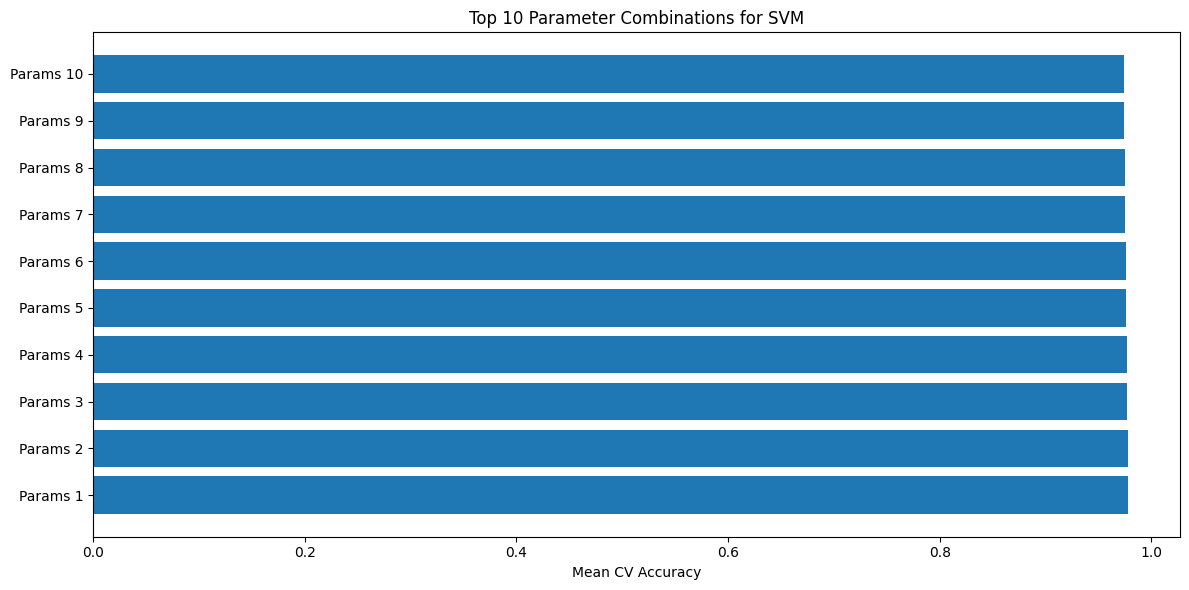

In [118]:
print("Hyperparameter Tuning for Best Model")
print("=" * 60)

if 'best_model_name' in locals() and best_model_name in models:
    from sklearn.model_selection import GridSearchCV

    print(f"Tuning hyperparameters for: {best_model_name}")

    # Define parameter grids based on model type
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        },
        'SVM': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        },
        'K-Nearest Neighbors': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
    }

    # Get appropriate parameter grid
    if best_model_name in param_grids:
        param_grid = param_grids[best_model_name]

        # Create base model
        base_model = models[best_model_name].__class__

        # Setup GridSearchCV
        grid_search = GridSearchCV(
            estimator=base_model(random_state=42),
            param_grid=param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='accuracy',
            n_jobs=-1,  # Use all available cores
            verbose=1
        )

        print(f"Performing grid search with {len(param_grid)} parameter combinations...")

        # Fit grid search
        grid_search.fit(X_train_scaled_df, y_train)

        print("\nGrid Search Results:")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

        # Evaluate on test set
        tuned_model = grid_search.best_estimator_
        y_pred_tuned = tuned_model.predict(X_test_scaled_df)
        tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

        print(f"Test Accuracy (Tuned): {tuned_accuracy:.4f}")

        # Compare with original
        original_accuracy = results[best_model_name]['test_accuracy']
        improvement = tuned_accuracy - original_accuracy

        print(f"\nComparison with Original Model:")
        print(f"Original Accuracy: {original_accuracy:.4f}")
        print(f"Tuned Accuracy: {tuned_accuracy:.4f}")
        print(f"Improvement: {improvement:.4f} ({improvement*100:.2f}%)")

        # Update best model if improved
        if improvement > 0:
            print("\nUpdating best model with tuned parameters...")
            best_model = tuned_model
            best_model_name = f"{best_model_name} (Tuned)"

            # Save the tuned model
            tuned_model_filename = 'saved_models/malaria_tuned_model.pkl'
            joblib.dump(tuned_model, tuned_model_filename)
            print(f"Tuned model saved as: {tuned_model_filename}")

        # Plot parameter performance
        if hasattr(grid_search, 'cv_results_'):
            results_df = pd.DataFrame(grid_search.cv_results_)

            # Get top 10 parameter combinations
            top_results = results_df.nsmallest(10, 'rank_test_score')

            plt.figure(figsize=(12, 6))
            plt.barh(range(len(top_results)), top_results['mean_test_score'])
            plt.yticks(range(len(top_results)), [f"Params {i+1}" for i in range(len(top_results))])
            plt.xlabel('Mean CV Accuracy')
            plt.title(f'Top 10 Parameter Combinations for {best_model_name}')
            plt.tight_layout()
            plt.show()

    else:
        print(f"No parameter grid defined for {best_model_name}")

else:
    print("Best model not found for tuning.")

### Creating Interactive Prediction Demo

In [119]:
print("Creating Interactive Prediction Demo")
print("=" * 60)

def interactive_malaria_predictor():
    """Interactive function for malaria prediction"""

    if 'best_model' not in locals():
        print("Error: Model not loaded. Please train the model first.")
        return

    print("Malaria Prediction System")
    print("-" * 30)
    print("Enter patient information and symptoms (1 for Yes, 0 for No)")
    print()

    try:
        # Get patient information
        age = int(input("Enter Age: "))

        print("\nGender (enter number):")
        print("0: Female")
        print("1: Male")
        gender = int(input("Gender: "))

        print("\nEnter symptoms (1 for Yes, 0 for No):")
        fever = int(input("Fever: "))
        headache = int(input("Headache: "))
        chills = int(input("Chills: "))
        sweating = int(input("Sweating: "))
        fatigue = int(input("Fatigue: "))
        nausea = int(input("Nausea: "))
        vomiting = int(input("Vomiting: "))
        muscle_pain = int(input("Muscle Pain: "))
        diarrhea = int(input("Diarrhea: "))

        # Create symptoms dictionary
        symptoms = {
            'Age': age,
            'Gender': gender,
            'Fever': fever,
            'Headache': headache,
            'Chills': chills,
            'Sweating': sweating,
            'Fatigue': fatigue,
            'Nausea': nausea,
            'Vomiting': vomiting,
            'Muscle_Pain': muscle_pain,
            'Diarrhea': diarrhea
        }

        # Make prediction
        result = predict_malaria_fixed(symptoms)

        # Display results
        print("\n" + "=" * 60)
        print("PREDICTION RESULTS")
        print("=" * 60)
        print(f"Model Used: {result['model_used']}")
        print(f"Prediction: {result['prediction_label']}")

        if result['probability_positive'] is not None:
            print(f"\nProbability Analysis:")
            print(f"Probability of Malaria: {result['probability_positive']:.2%}")
            print(f"Probability of No Malaria: {result['probability_negative']:.2%}")

            # Risk assessment
            if result['probability_positive'] > 0.7:
                print("\nRISK LEVEL: HIGH")
                print("Recommendation: Immediate medical attention recommended")
            elif result['probability_positive'] > 0.3:
                print("\nRISK LEVEL: MODERATE")
                print("Recommendation: Medical consultation advised")
            else:
                print("\nRISK LEVEL: LOW")
                print("Recommendation: Monitor symptoms, consult if worsens")

        # Show key symptoms
        print(f"\nKey Symptoms Provided:")
        positive_symptoms = [symptom for symptom, value in symptoms.items()
                           if value == 1 and symptom not in ['Age', 'Gender']]

        if positive_symptoms:
            for symptom in positive_symptoms:
                print(f"  ✓ {symptom}")
        else:
            print("  No symptoms reported")

        print("\n" + "=" * 60)

    except ValueError:
        print("\nError: Please enter valid numbers (0 or 1 for symptoms)")
    except Exception as e:
        print(f"\nError: {e}")

# Also create a quick batch prediction function
def batch_predict(patients_list):
    """Predict for multiple patients at once"""
    predictions = []

    for i, patient in enumerate(patients_list):
        try:
            result = predict_malaria_fixed(patient)
            predictions.append({
                'patient_id': i+1,
                'prediction': result['prediction_label'],
                'probability': result['probability_positive']
            })
        except Exception as e:
            predictions.append({
                'patient_id': i+1,
                'error': str(e)
            })

    return pd.DataFrame(predictions)

# Example of batch prediction
print("\nExample: Batch Prediction for 3 Patients")
print("-" * 40)

example_patients = [
    {
        'Age': 25,
        'Gender': 1,
        'Fever': 1,
        'Headache': 1,
        'Chills': 1,
        'Sweating': 0,
        'Fatigue': 1,
        'Nausea': 0,
        'Vomiting': 0,
        'Muscle_Pain': 1,
        'Diarrhea': 0
    },
    {
        'Age': 40,
        'Gender': 0,
        'Fever': 0,
        'Headache': 0,
        'Chills': 0,
        'Sweating': 0,
        'Fatigue': 0,
        'Nausea': 0,
        'Vomiting': 0,
        'Muscle_Pain': 0,
        'Diarrhea': 0
    },
    {
        'Age': 30,
        'Gender': 1,
        'Fever': 1,
        'Headache': 0,
        'Chills': 0,
        'Sweating': 1,
        'Fatigue': 1,
        'Nausea': 1,
        'Vomiting': 0,
        'Muscle_Pain': 0,
        'Diarrhea': 1
    }
]

if 'best_model' in locals():
    batch_results = batch_predict(example_patients)
    print("Batch Prediction Results:")
    display(batch_results)

    # Option to run interactive demo
    print("\nWould you like to run the interactive predictor?")
    print("Uncomment the line below to run:")
    print("interactive_malaria_predictor()")
else:
    print("Model not available for batch prediction.")

Creating Interactive Prediction Demo

Example: Batch Prediction for 3 Patients
----------------------------------------
Batch Prediction Results:


,patient_id,prediction,probability
0,1,Malaria Positive,0.681066
1,2,Malaria Negative,0.000512
2,3,Malaria Positive,0.876201



Would you like to run the interactive predictor?
Uncomment the line below to run:
interactive_malaria_predictor()


### FINAL MODEL SUMMARY

In [120]:
print("FINAL MODEL SUMMARY")
print("=" * 60)

# Display final model information
if 'best_model' in locals():
    print(f"Best Model: {best_model_name}")
    print(f"Model Type: {type(best_model).__name__}")

    # Final evaluation
    y_pred_final = best_model.predict(X_test_scaled_df)
    final_accuracy = accuracy_score(y_test, y_pred_final)
    final_cm = confusion_matrix(y_test, y_pred_final)

    print(f"\nFinal Model Performance:")
    print(f"Test Accuracy: {final_accuracy:.4f}")
    print(f"Confusion Matrix:\n{final_cm}")

    # Calculate key metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

    precision = precision_score(y_test, y_pred_final)
    recall = recall_score(y_test, y_pred_final)
    f1 = f1_score(y_test, y_pred_final)

    print(f"\nDetailed Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # ROC-AUC if probabilities available
    if hasattr(best_model, 'predict_proba'):
        y_pred_proba = best_model.predict_proba(X_test_scaled_df)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Feature importance summary
    print(f"\nTop 5 Most Important Features:")

    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        for i, row in feature_importance.head().iterrows():
            print(f"  {row['Feature']}: {row['Importance']:.4f}")

    elif hasattr(best_model, 'coef_'):
        coefficients = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': best_model.coef_[0],
            'Abs_Coefficient': np.abs(best_model.coef_[0])
        }).sort_values('Abs_Coefficient', ascending=False)

        for i, row in coefficients.head().iterrows():
            print(f"  {row['Feature']}: {row['Coefficient']:.4f}")

    print(f"\nModel Deployment Files:")
    print("✓ malaria_best_model.pkl - Trained model")
    print("✓ malaria_scaler.pkl - Feature scaler")
    print("✓ feature_names.pkl - Feature names")
    print("✓ all_malaria_models.pkl - All trained models")
    print("✓ model_results.pkl - Model performance results")

    print(f"\nNext Steps for Deployment:")
    print("1. Use predict_malaria_fixed() function for predictions")
    print("2. Load saved models with joblib.load()")
    print("3. Create a web API using Flask/FastAPI")
    print("4. Build a simple GUI with Tkinter or Streamlit")

    # Save final summary
    summary = {
        'best_model_name': best_model_name,
        'test_accuracy': final_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': final_cm.tolist(),
        'feature_names': X.columns.tolist(),
        'model_type': type(best_model).__name__
    }

    import json
    with open('saved_models/model_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nSummary saved to: saved_models/model_summary.json")

else:
    print("Model not available for summary.")

FINAL MODEL SUMMARY
Best Model: SVM
Model Type: SVC

Final Model Performance:
Test Accuracy: 0.9875
Confusion Matrix:
[[527   5]
 [  4 184]]

Detailed Metrics:
Precision: 0.9735
Recall: 0.9787
F1-Score: 0.9761
ROC-AUC Score: 0.9989

Top 5 Most Important Features:

Model Deployment Files:
✓ malaria_best_model.pkl - Trained model
✓ malaria_scaler.pkl - Feature scaler
✓ feature_names.pkl - Feature names
✓ all_malaria_models.pkl - All trained models
✓ model_results.pkl - Model performance results

Next Steps for Deployment:
1. Use predict_malaria_fixed() function for predictions
2. Load saved models with joblib.load()
3. Create a web API using Flask/FastAPI
4. Build a simple GUI with Tkinter or Streamlit

Summary saved to: saved_models/model_summary.json
